Using device: cpu
Using model: mrm8488/spanbert-finetuned-squadv2

PREPROCESSING DATA FOR CANDIDATE-BASED EVALUATION
Preprocessing complete. Created 267 pronoun instances.
Class distribution:
is_ambiguous_label
0    0.573034
1    0.426966
Name: proportion, dtype: float64

STEP 1: Creating Train(Tune)/Test Split
Train/Tune Set Size: 186
Test Set Size:       81

STEP 2: Empirically Tuning SOFTMAX PROBABILITY Threshold on Train Set


Tuning Threshold:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/24 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/24 [00:00<?, ?it/s]


Best probability threshold found: 0.05
Best F1 (Ambiguous) on Train Set: 0.3636

STEP 3: Evaluating on Test Set with candidate score threshold = 0.05


Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

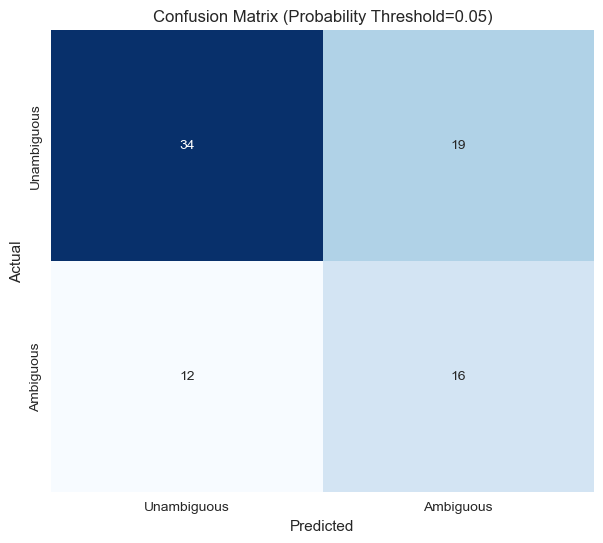


CLASSIFICATION REPORT (Methodology: Candidate Counting) (Probability Threshold=0.05)
              precision    recall  f1-score   support

 Unambiguous     0.7391    0.6415    0.6869        53
   Ambiguous     0.4571    0.5714    0.5079        28

    accuracy                         0.6173        81
   macro avg     0.5981    0.6065    0.5974        81
weighted avg     0.6417    0.6173    0.6250        81


PIPELINE COMPLETE


In [ ]:
import os
import torch
import spacy
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForQuestionAnswering
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (confusion_matrix, classification_report,
                             precision_recall_fscore_support, accuracy_score, f1_score)
from sklearn.model_selection import train_test_split
import warnings
from tqdm.auto import tqdm

warnings.filterwarnings('ignore')

# -------------------------
# Config
# -------------------------
MODEL_NAME = "mrm8488/spanbert-finetuned-squadv2"
TOKENIZER_NAME = "SpanBERT/spanbert-base-cased"
SPACY_MODEL = "en_core_web_sm"

DATA_PATH = "anaphoric_ambiguity_spanbert_input.csv"
BATCH_SIZE = 8 
MAX_LENGTH = 256
TEST_SET_SIZE = 0.3
RANDOM_SEED = 42

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Reproducibility
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# -------------------------
# spaCy for Candidate Extraction
# -------------------------
try:
    nlp = spacy.load(SPACY_MODEL)
except OSError:
    print(f"Spacy model '{SPACY_MODEL}' not found. Downloading...")
    spacy.cli.download(SPACY_MODEL)
    nlp = spacy.load(SPACY_MODEL)

def extract_candidates(spacy_doc, pronoun_char_start):
    """
    Extracts all noun chunks that appear before the pronoun's start character.
    This directly addresses Concern #4.
    """
    return [chunk for chunk in spacy_doc.noun_chunks if chunk.end_char < pronoun_char_start]

# -------------------------
# Data / Dataset
# -------------------------

def preprocess_for_evaluation(df):
    """
    UPDATED: Now also extracts the character start position of the pronoun,
    which is essential for candidate extraction.
    """
    print("\n" + "="*60)
    print("PREPROCESSING DATA FOR CANDIDATE-BASED EVALUATION")
    print("="*60)
    
    df['group_id'] = df['Id'].apply(lambda x: '-'.join(x.split('-')[:2]))
    evaluation_data = []

    for group_id, group_df in df.groupby('group_id'):
        context_hashed = group_df['Hashed_Context'].iloc[0]
        pronoun = group_df['Pronoun'].iloc[0]
        is_ambiguous = 0 if group_df['Manual Evaluation'].iloc[0] == 'UA' else 1
        
        # Find the hashed pronoun to get its unique position
        pronoun_marker = ""
        for i in range(5): # Check for #0, #1, #2 etc.
            if f"{pronoun}#{i}" in context_hashed:
                pronoun_marker = f"{pronoun}#{i}"
                break
        
        if not pronoun_marker:
            # Fallback for unhashed pronouns
            pronoun_char_start = context_hashed.find(pronoun)
        else:
            pronoun_char_start = context_hashed.find(pronoun_marker)
            
        context_clean = context_hashed.replace(pronoun_marker, pronoun)

        if pronoun_char_start != -1:
            evaluation_data.append({
                'group_id': group_id,
                'pronoun': pronoun,
                'context_clean': context_clean,
                'is_ambiguous_label': is_ambiguous,
                'pronoun_char_start': pronoun_char_start,
            })

    eval_df = pd.DataFrame(evaluation_data)
    print(f"Preprocessing complete. Created {len(eval_df)} pronoun instances.")
    print(f"Class distribution:\n{eval_df['is_ambiguous_label'].value_counts(normalize=True)}")
    return eval_df

class AnaphoraDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=128):
        self.data = dataframe.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        context = row['context_clean']
        pronoun = row['pronoun']
        question = f"What does '{pronoun}' refer to?"
        
        encoding = self.tokenizer(
            question,
            context,
            truncation='only_second',
            padding='max_length',
            max_length=self.max_length,
            return_offsets_mapping=True, # mapping candidates to tokens
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'token_type_ids': encoding['token_type_ids'].flatten(),
            'offset_mapping': encoding['offset_mapping'], # Pass this to the model
            'label': torch.tensor(row['is_ambiguous_label'], dtype=torch.long),
            'context': context, # Pass context for spaCy processing
            'pronoun_char_start': row['pronoun_char_start']
        }

# -------------------------
# Evaluation Logic based on Multiple Candidates
# -------------------------

def get_predictions_with_softmax(model, dataloader, device, prob_threshold):
    """
    FINAL, ROBUST LOGIC.
    Uses Softmax to normalize candidate scores into a probability distribution.
    Ambiguity is now defined as having multiple candidates with a meaningful share of the
    total probability. This directly measures if the model is "conflicted".
    """
    model.eval()
    model.to(device)
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            # Input preparation
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            labels = batch['label']

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
            start_logits_batch = outputs.start_logits
            end_logits_batch = outputs.end_logits
            
            for i in range(len(input_ids)):
                context = batch['context'][i]
                pronoun_char_start = batch['pronoun_char_start'][i].item()
                spacy_doc = nlp(context)
                candidates = extract_candidates(spacy_doc, pronoun_char_start)
                
                candidate_scores = []
                
                if candidates:
                    start_logits = start_logits_batch[i]
                    end_logits = end_logits_batch[i]
                    offset_mapping = batch['offset_mapping'][i].squeeze()
                    
                    for cand in candidates:
                        cand_char_start, cand_char_end = cand.start_char, cand.end_char
                        start_token_idx, end_token_idx = -1, -1
                        context_mask = (batch['token_type_ids'][i] == 1)

                        for token_idx, (start_char, end_char) in enumerate(offset_mapping):
                            if not context_mask[token_idx]: continue
                            if start_token_idx == -1 and start_char >= cand_char_start:
                                start_token_idx = token_idx
                            if end_char >= cand_char_end:
                                end_token_idx = token_idx
                                break
                        
                        if start_token_idx != -1 and end_token_idx != -1:
                            span_score = start_logits[start_token_idx] + end_logits[end_token_idx]
                            candidate_scores.append(span_score.item())
                
                plausible_candidate_count = 0
                if candidate_scores:
                    # Apply Softmax to get a probability distribution
                    probabilities = torch.softmax(torch.tensor(candidate_scores), dim=0)
                    
                    # Count how many candidates have a probability above the threshold
                    plausible_candidate_count = torch.sum(probabilities > prob_threshold).item()

                predicted_label = 1 if plausible_candidate_count >= 2 else 0
                all_preds.append(predicted_label)
                all_labels.append(labels[i].item())

    return np.array(all_preds), np.array(all_labels)


def tune_softmax_threshold(model, dataloader, device):
    """
    Tunes the PROBABILITY threshold for the Softmax logic.
    """
    print("\n" + "="*60)
    print("STEP 2: Empirically Tuning SOFTMAX PROBABILITY Threshold on Train Set")
    print("="*60)
    
    # Thresholds probabilities between 0 and 1
    thresholds_to_test = np.arange(0.05, 0.5, 0.05) 
    best_f1 = -1
    best_threshold = 0.0
    
    for threshold in tqdm(thresholds_to_test, desc="Tuning Threshold"):
        preds, labels = get_predictions_with_softmax(model, dataloader, device, threshold)
        f1 = f1_score(labels, preds, pos_label=1, zero_division=0)
        
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
            
    print(f"\nBest probability threshold found: {best_threshold:.2f}")
    print(f"Best F1 (Ambiguous) on Train Set: {best_f1:.4f}")
    return best_threshold

# -------------------------
# Metrics and Plotting 
# -------------------------
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary', pos_label=1, zero_division=0)
    return {'accuracy': accuracy, 'precision_ambiguous': precision, 'recall_ambiguous': recall, 'f1_ambiguous': f1}

def plot_confusion_matrix_and_report(y_true, y_pred, class_names=['Unambiguous', 'Ambiguous'], title_suffix=""):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(7, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names, cbar=False)
    plt.xlabel('Predicted'); plt.ylabel('Actual')
    plt.title(f'Confusion Matrix{title_suffix}')
    plt.show()

    print("\n" + "="*60)
    print(f"CLASSIFICATION REPORT (Methodology: Candidate Counting){title_suffix}")
    print("="*60)
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4, zero_division=0))

# -------------------------
# Main Execution
# -------------------------
if __name__ == "__main__":
    print(f"Using device: {DEVICE}")
    print(f"Using model: {MODEL_NAME}")
    
    try:
        raw_df = pd.read_csv(DATA_PATH)
        eval_df = preprocess_for_evaluation(raw_df)
        
        print("\n" + "="*60 + "\nSTEP 1: Creating Train(Tune)/Test Split\n" + "="*60)
        train_df, test_df = train_test_split(eval_df, test_size=TEST_SET_SIZE, random_state=RANDOM_SEED, stratify=eval_df['is_ambiguous_label'])
        print(f"Train/Tune Set Size: {len(train_df)}")
        print(f"Test Set Size:       {len(test_df)}")

        tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_NAME)
        model = AutoModelForQuestionAnswering.from_pretrained(MODEL_NAME)
        model.to(DEVICE)
        
        train_dataset = AnaphoraDataset(train_df, tokenizer, max_length=MAX_LENGTH)
        test_dataset = AnaphoraDataset(test_df, tokenizer, max_length=MAX_LENGTH)
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
        
        best_threshold = tune_softmax_threshold(model, train_loader, DEVICE)
        
        print("\n" + "="*60 + f"\nSTEP 3: Evaluating on Test Set with candidate score threshold = {best_threshold:.2f}\n" + "="*60)
        final_preds, final_labels = get_predictions_with_softmax(model, test_loader, DEVICE, prob_threshold=best_threshold) 
        
        plot_confusion_matrix_and_report(final_preds, final_labels, title_suffix=f" (Probability Threshold={best_threshold:.2f})")

    except FileNotFoundError:
        print(f"Error: Data file not found at {DATA_PATH}")

    print("\n" + "="*60 + "\nPIPELINE COMPLETE\n" + "="*60)